In [3]:
# Load the JSON data into Python
with open('News_Category_Dataset_v3.json') as f:
    data = f.readlines()

# Flatten the JSON data into a tabular format using pandas
df_list = []
for d in data:
    json_data = json.loads(d)
    df = pd.json_normalize(json_data)
    df_list.append(df)

# Concatenate the tabular data into a single DataFrame
df = pd.concat(df_list, ignore_index=True)

# Export the tabular data to a CSV file
df.to_csv('data_test.csv', index=False)

In [68]:
import pandas as pd
import json
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import math
import scipy.sparse
import sklearn.metrics.pairwise
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation#MiniBatchNMF
from sklearn.datasets import fetch_20newsgroups

In [40]:
data = pd.read_csv("data.csv")
data.shape

(209527, 6)

In [41]:
data.dropna(inplace=True)
data.reset_index(drop=True,inplace=True)
data.shape

(156859, 6)

In [42]:
data.head(1)

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",23-09-2022


## CountVectorizer

In [73]:
from sklearn.feature_extraction.text import CountVectorizer
# count vectoriser: allows us to the bag-of -words approach by counting the collection of text documents 
#into matrix of token counts
#Bags of words approach:simple and commonly used way to represent text for we in ML, which ignores 
#structure & only counts how often each word occures
vect = CountVectorizer().fit(data.short_description)
len(vect.get_feature_names())

68768

In [74]:
vectorized_word_feature = vect.transform(data.short_description)
vectorized_word_feature

<156859x68768 sparse matrix of type '<class 'numpy.int64'>'
	with 3018680 stored elements in Compressed Sparse Row format>

In [75]:
# get the feature names as numpy array
feature_names = np.array(vect.get_feature_names())
# Sort the coefficients from the model
sorted_coef_index = vectorized_word_feature.max(0).toarray()[0].argsort()

# Find the 10 smallest and 10 largest coefficients
# The 10 largest coefficients are being indexed using [:-11:-1] 
# so the list returned is in order of largest to smallest
print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs:
['kyoto' 'ortigia' 'ortiz' 'orvieto' 'orville' 'orwell' 'orwellian' 'ory'
 'os' 'osa']

Largest Coefs: 
['the' 'cake' 'black' 'bodies' 'to' 'it' 'you' 'and' 'of' 'chocolate']


In [76]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
    }

# A list holds the SSE values for each k
sse = []
for k in range(5, 25, 5):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(vectorized_word_feature)
    sse.append(kmeans.inertia_)

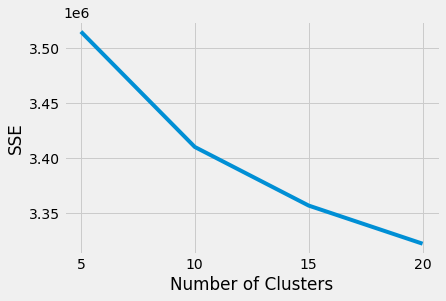

In [77]:
plt.style.use("fivethirtyeight")
plt.plot(range(5, 25, 5), sse)
plt.xticks(range(5, 25, 5))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [78]:
kmeans = KMeans(init="random",n_clusters=10,n_init=10,max_iter=300,random_state=42)
kmeans.fit(vectorized_word_feature)
kmeans.labels_

array([5, 5, 6, ..., 8, 0, 4], dtype=int32)

In [79]:
data['cluster_label_cnt_vec'] = kmeans.labels_

In [80]:
data.head(1)

,link,headline,category,short_description,authors,date,cluster_label_cnt_vec
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",23-09-2022,5


## Tfidf

In [43]:
#from sklearn.feature_extraction.text import TfidfVectorizer
# Fit the TfidfVectorizer to the training data specifiying a minimum document frequency of 5
n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20
batch_size = 128
init = "nndsvda"

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=30, max_features=n_features, stop_words="english")
tfidf = tfidf_vectorizer.fit_transform(data.short_description)
#len(tfidf.get_feature_names())

In [44]:
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=1,
).fit(tfidf)

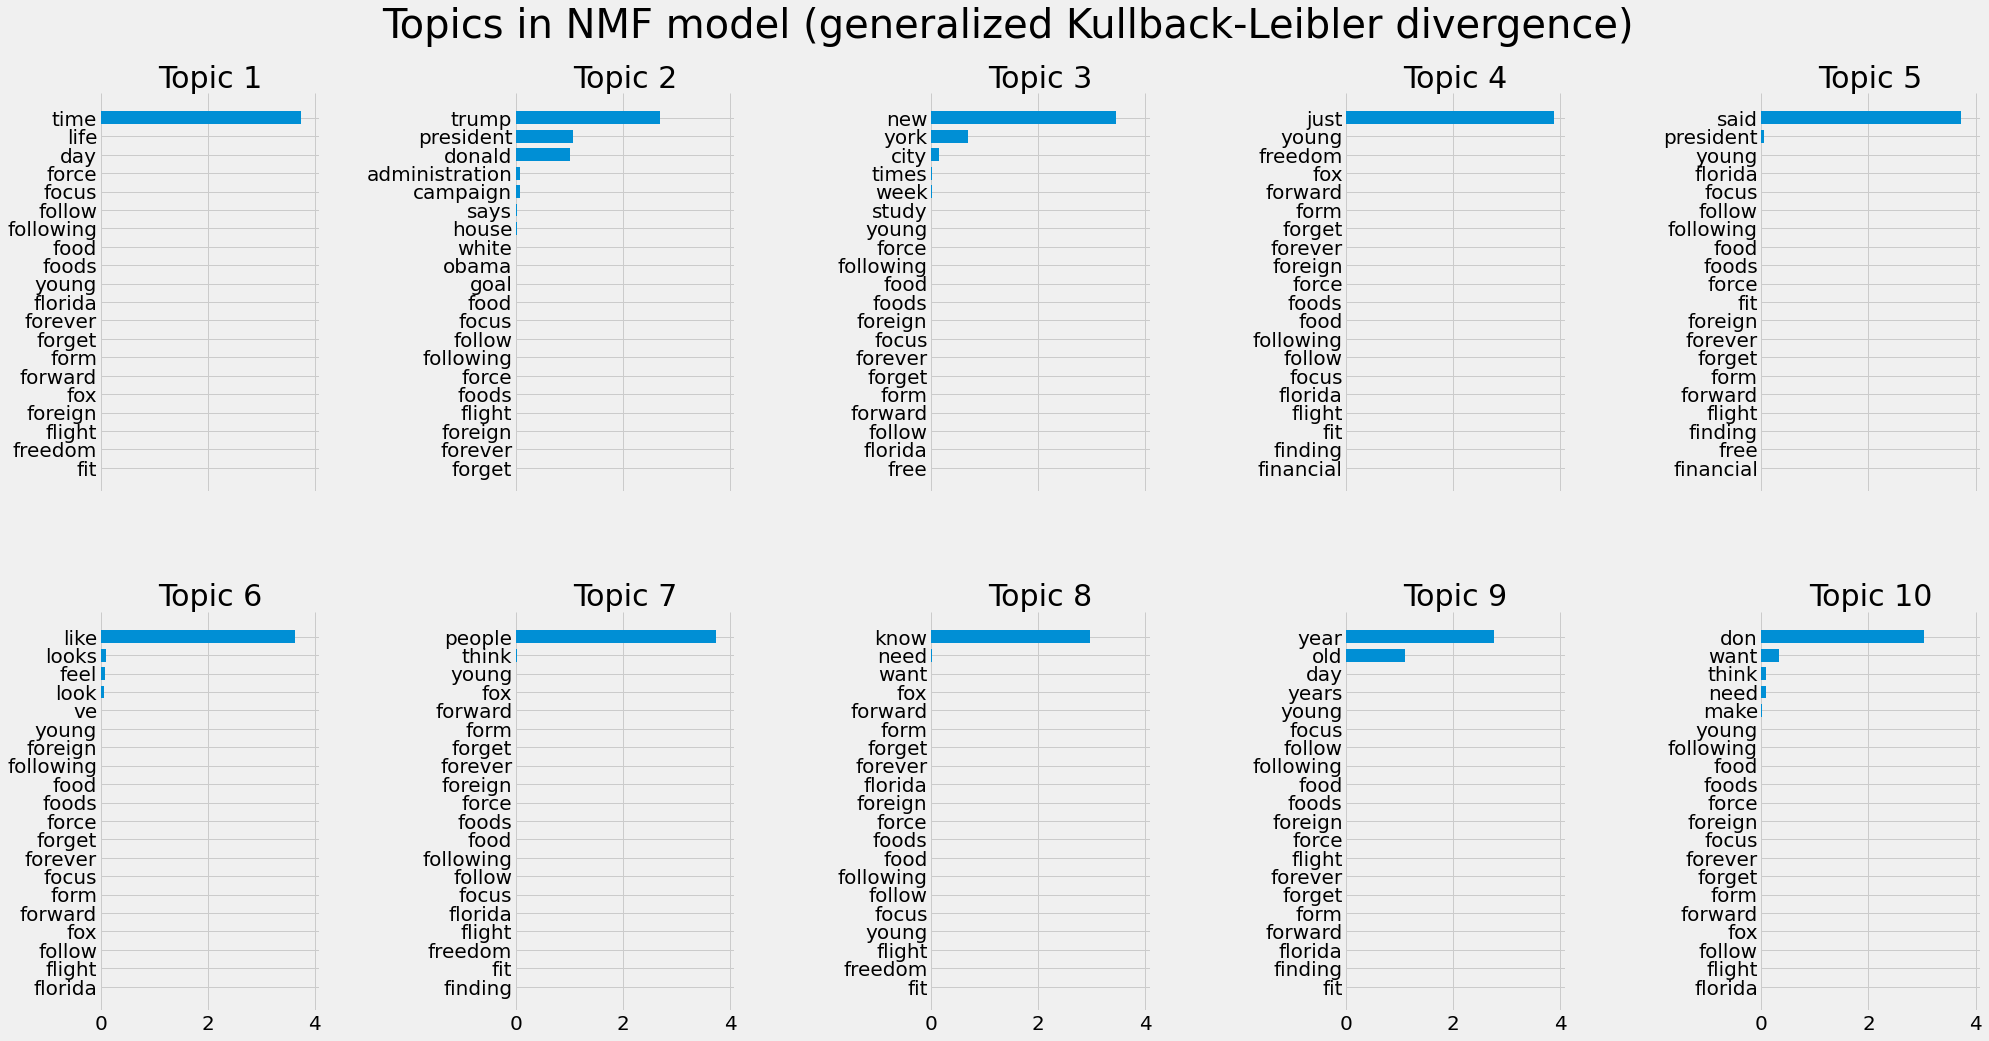

In [45]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
)

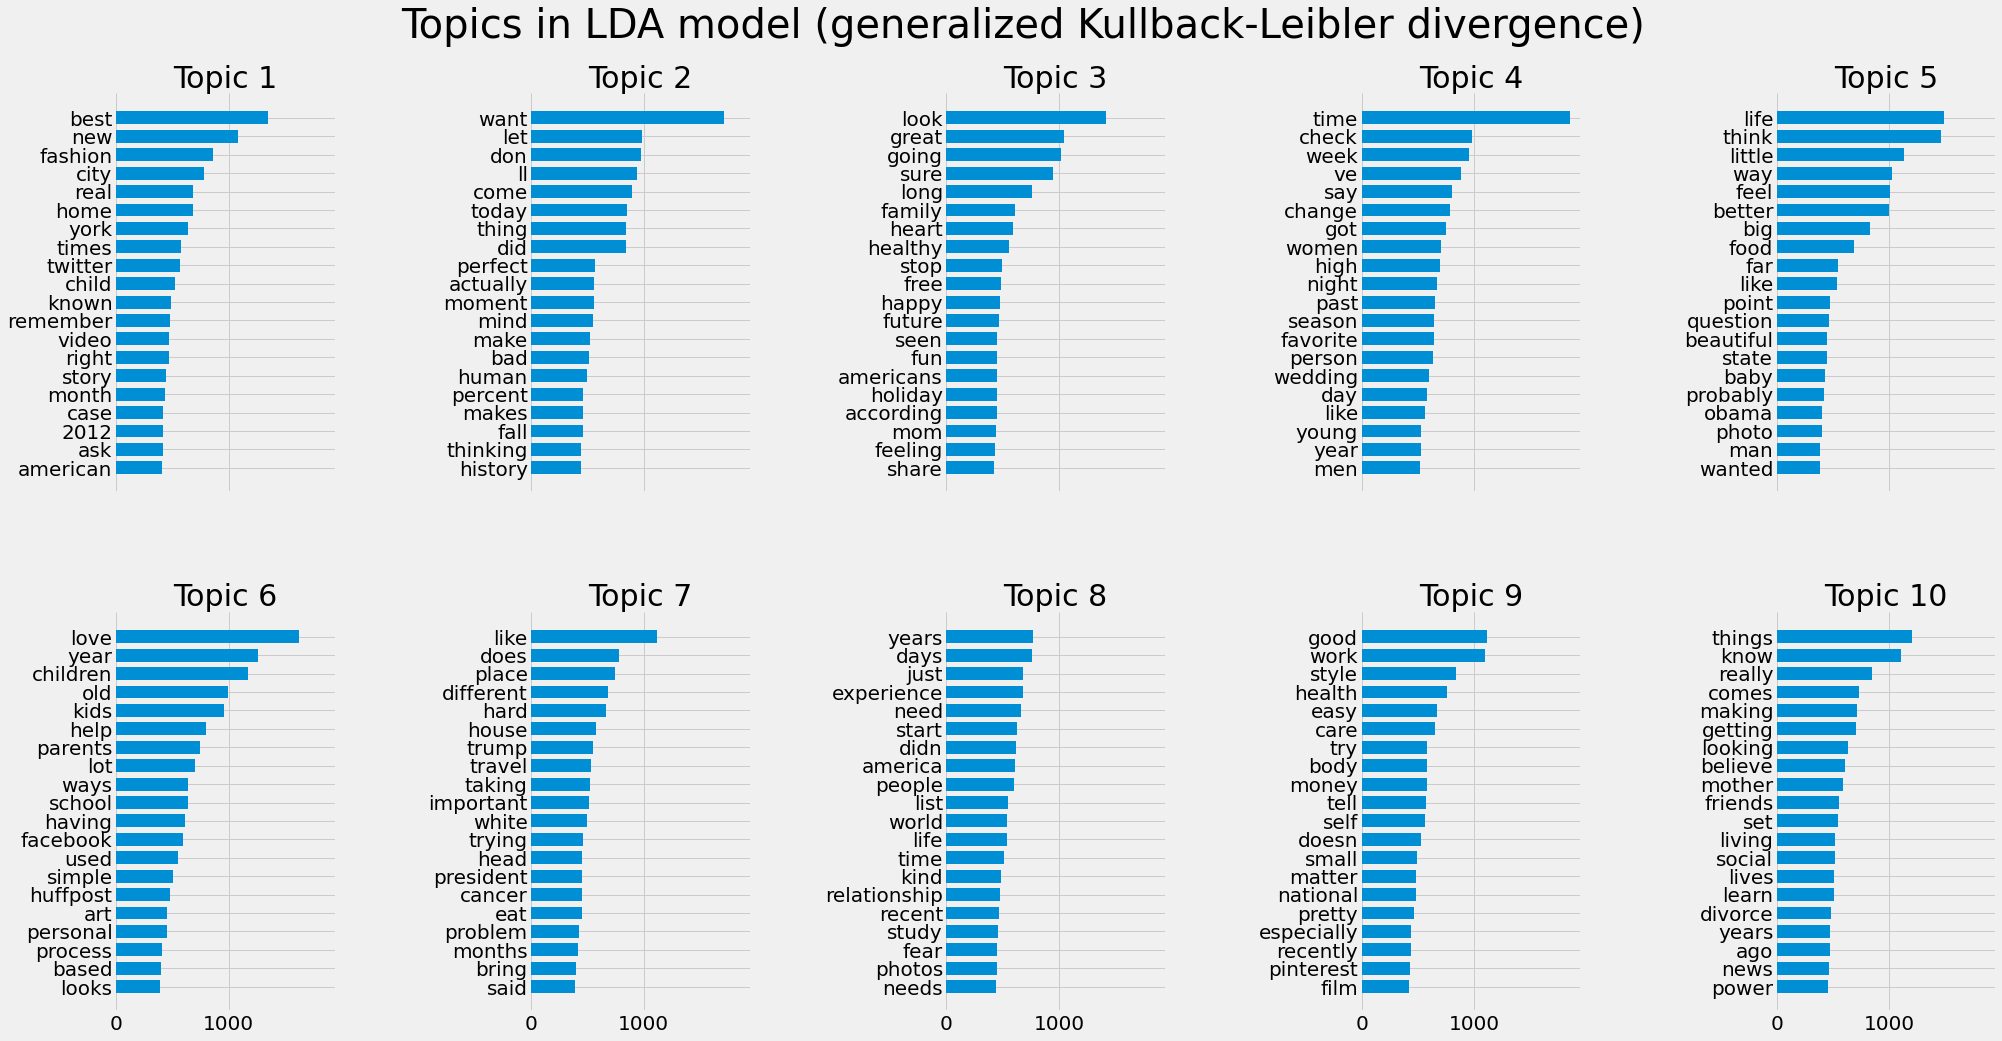

In [46]:
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
).fit(tfidf)
plot_top_words(
    lda,
    tfidf_feature_names,
    n_top_words,
    "Topics in LDA model (generalized Kullback-Leibler divergence)",
)

In [47]:
vectorized_word_feature = tfidf_vectorizer.transform(data.short_description)
vectorized_word_feature

<156859x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 802699 stored elements in Compressed Sparse Row format>

In [48]:
feature_names = np.array(tfidf_vectorizer.get_feature_names())

sorted_tfidf_index = vectorized_word_feature.max(0).toarray()[0].argsort()

print('Smallest tfidf:\n{}\n'.format(feature_names[sorted_tfidf_index[:10]]))
print('Largest tfidf: \n{}'.format(feature_names[sorted_tfidf_index[:-11:-1]]))

Smallest tfidf:
['spiritual' 'ago' 'opportunity' 'tumblr' 'york' 'treatment' 'aware'
 'nominee' 'physical' 'muslim']

Largest tfidf: 
['young' 'florida' 'free' 'fox' 'forward' 'form' 'forget' 'forever'
 'foreign' 'force']


/Users/summerwang/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [38]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
    }

# A list holds the SSE values for each k
sse = []
for k in range(5, 35, 5):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(vectorized_word_feature)
    sse.append(kmeans.inertia_)

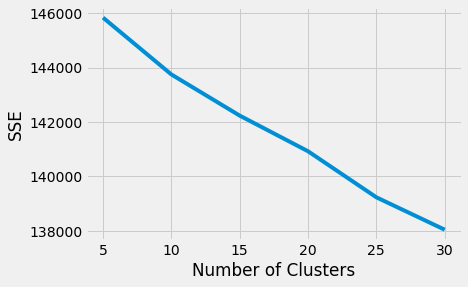

In [39]:
plt.style.use("fivethirtyeight")
plt.plot(range(5, 35, 5), sse)
plt.xticks(range(5, 35, 5))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [49]:
kmeans = KMeans(init="random",n_clusters=30,n_init=10,max_iter=300,random_state=42)
kmeans.fit(vectorized_word_feature)
kmeans.labels_

array([ 8, 21, 22, ..., 29,  2, 21], dtype=int32)

In [61]:
vectorized_word_feature[35842]

<1x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 5 stored elements in Compressed Sparse Row format>

In [50]:
kmeans.inertia_

138044.68728733074

In [51]:
data['cluster_label_tfidf'] = kmeans.labels_

In [52]:
data.head(1)

,link,headline,category,short_description,authors,date,cluster_label_tfidf
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",23-09-2022,8


In [54]:
data.cluster_label_tfidf.value_counts()

21    80259
0      5468
6      5024
23     4965
22     4776
12     4704
26     4569
14     4152
19     4086
3      3760
18     3593
11     3281
10     3238
5      2924
2      2624
13     2248
28     2121
8      2105
16     2073
7      2000
25     1413
4      1311
27     1311
24     1292
1       753
20      685
9       582
29      577
17      518
15      447
Name: cluster_label_tfidf, dtype: int64

In [87]:
sampling_pool = list(data.index)
init_sample_num = 5
sub_sample_num = 20
init_article = random.sample(sampling_pool,init_sample_num)
init_article

[2226, 148498, 112028, 81704, 61448]

In [73]:
df = pd.DataFrame(init_article,columns=['relate'])
df

,0
0,106065
1,3492
2,141867
3,60501
4,115048


In [65]:
data.iloc[1].cluster_label_tfidf

21

In [84]:
t = pd.DataFrame(data.iloc[0]).T
t = pd.concat([t,t])
t[1:]

,link,headline,category,short_description,authors,date,cluster_label_tfidf
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",23-09-2022,8


In [ ]:
for init in init_article:
    c_tag = data.iloc[init].cluster_label_tfidf
    sub_sampling_pool = list(data[data.cluster_label_tfidf==c_tag].index)
    sub_sample_article = random.sample(sub_sampling_pool,sub_sample_num)
    dist_list = []
    init_art_vector = vectorized_word_feature[init]
    for sub_a in sub_sample_article:
        comp_art_vector = vectorized_word_feature[sub_a]
        art_dist = sklearn.metrics.pairwise.pairwise_distances(init_art_vector,comp_art_vector)[0][0]
        dist_list.append(art_dist)

In [85]:
def generate_user_reading_records(init_sample_num,sub_sample_num,data,vectorized_word_feature):
    sampling_pool = list(data.index)
    init_article = random.sample(sampling_pool,init_sample_num)
    records_df = pd.DataFrame(data.iloc[0]).T
    records_df['art_dist'] = 0
    records_df['init_art'] = 0
    for init in init_article:
        c_tag = data.iloc[init].cluster_label_tfidf
        sub_sampling_pool = list(data[data.cluster_label_tfidf==c_tag].index)
        sub_sample_article = random.sample(sub_sampling_pool,sub_sample_num)
        init_art_vector = vectorized_word_feature[init]
        for sub_a in sub_sample_article:
            comp_art_vector = vectorized_word_feature[sub_a]
            art_dist = sklearn.metrics.pairwise.pairwise_distances(init_art_vector,comp_art_vector)[0][0]
            records_tmp = pd.DataFrame(data.iloc[sub_a]).T
            records_tmp['art_dist'] = art_dist
            records_tmp['init_art'] = init
            records_df = pd.concat([records_df,records_tmp])
    records_df = records_df[1:]
    return records_df

In [88]:
dt = generate_user_reading_records(init_sample_num,sub_sample_num,data,vectorized_word_feature)

In [93]:
user_id = 0
reading_records = generate_user_reading_records(init_sample_num,sub_sample_num,data,vectorized_word_feature)
reading_records['user_id'] = user_id
for id_ in range(100):
    reading_records_tmp = generate_user_reading_records(init_sample_num,sub_sample_num,data,vectorized_word_feature)
    reading_records_tmp['user_id'] = id_
    reading_records = pd.concat([reading_records,reading_records_tmp])
reading_records = reading_records[100:]
reading_records.shape

(10000, 10)

In [94]:
reading_records.head()

,link,headline,category,short_description,authors,date,cluster_label_tfidf,art_dist,init_art,user_id
101545,https://www.huffingtonpost.com/entry/yet-anoth...,Why It's Not Okay for Andrew Garfield to Play ...,QUEER VOICES,"It would be nice, for once, if actual transgen...","Bustle, ContributorNews, entertainment, lifest...",06-06-2014,28,1.313663,129414,0
57779,https://www.huffingtonpost.com/entry/mike-penc...,"Mike Pence Flip-Flops, Aligns With Trump On Im...",POLITICS,He now apparently believes “we’ve got to find ...,Chris D'Angelo,16-07-2016,28,1.157945,129414,0
113323,https://www.huffingtonpost.com/entry/walmart-p...,Walmart Wage Protest Leads To Arrest Of Man Dr...,BUSINESS,“I'm going to get arrested for civil disobedie...,Harry Bradford,29-11-2013,28,1.318516,129414,0
125239,https://www.huffingtonpost.com/entry/who-volun...,Who Volunteers in Haiti?,TRAVEL,I remember the first time I prepared to go to ...,"Elevate Destinations, Contributor\nEco-luxury ...",21-05-2013,28,1.336311,129414,0
148902,https://www.huffingtonpost.com/entry/motherhoo...,Women vs. Mothers,PARENTING,There's a whole lot of warfare going on over u...,"Hayley Krischer, Contributor\nWriter",22-05-2012,28,1.244789,129414,0


## n-grams

In [89]:
vect = CountVectorizer(min_df=5, ngram_range=(1,2)).fit(data.short_description)
vectorized_word_feature = vect.transform(data.short_description)
len(vect.get_feature_names())

/Users/summerwang/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


108550

In [90]:
vectorized_word_feature = vect.transform(data.short_description)
vectorized_word_feature

<156859x108550 sparse matrix of type '<class 'numpy.int64'>'
	with 4889593 stored elements in Compressed Sparse Row format>

In [91]:
feature_names = np.array(vect.get_feature_names())

sorted_ngrams_index = vectorized_word_feature.max(0).toarray()[0].argsort()

print('Smallest tfidf:\n{}\n'.format(feature_names[sorted_ngrams_index[:10]]))
print('Largest tfidf: \n{}'.format(feature_names[sorted_ngrams_index[:-11:-1]]))

Smallest tfidf:
['marry him' 'pine' 'pinch' 'pimp' 'pillows' 'pillow and' 'pillars of'
 'pillars' 'pillar of' 'pillar']

Largest tfidf: 
['the' 'cake' 'black' 'to' 'bodies' 'chocolate' 'and' 'it' 'of' 'you']


In [92]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
    }

# A list holds the SSE values for each k
sse = []
for k in range(5, 25, 5):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(vectorized_word_feature)
    sse.append(kmeans.inertia_)

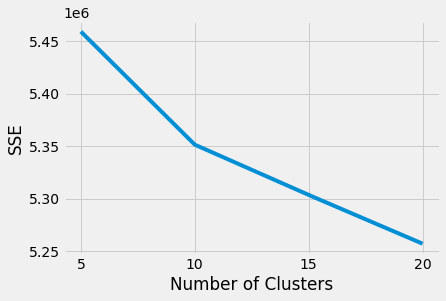

In [93]:
plt.style.use("fivethirtyeight")
plt.plot(range(5, 25, 5), sse)
plt.xticks(range(5, 25, 5))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [94]:
kmeans = KMeans(init="random",n_clusters=10,n_init=10,max_iter=300,random_state=42)
kmeans.fit(vectorized_word_feature)
kmeans.labels_

array([0, 0, 2, ..., 1, 4, 9], dtype=int32)

In [95]:
data['cluster_label_ngrams'] = kmeans.labels_

In [96]:
data.head(1)

,link,headline,category,short_description,authors,date,cluster_label_cnt_vec,cluster_label_tfidf,cluster_label_ngrams
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",23-09-2022,5,3,0


In [97]:
data.cluster_label_cnt_vec.value_counts()

6    56691
8    27472
0    23358
2    12364
5     9347
4     9239
3     8004
1     6207
7     3910
9      267
Name: cluster_label_cnt_vec, dtype: int64

In [98]:
data.cluster_label_tfidf.value_counts()

5    54817
4    34514
1    13823
9    13397
6    10437
8     9147
7     7773
0     6870
3     5471
2      610
Name: cluster_label_tfidf, dtype: int64

In [99]:
data.cluster_label_ngrams.value_counts()

2    55953
1    27347
4    23195
7    13018
9     9358
0     9319
8     8149
5     6318
6     3949
3      253
Name: cluster_label_ngrams, dtype: int64

In [ ]:
#https://realpython.com/k-means-clustering-python/
#https://www.kaggle.com/code/jojushaji/sentimental-analysis-on-amazon-reviews/notebook
#https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py

In [113]:
# using tfidf
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.8, min_samples=500)
dbscan.fit(vectorized_word_feature)

DBSCAN(eps=0.8, min_samples=500)

In [114]:
data['cluster_label_dbscan'] = dbscan.labels_
data.cluster_label_dbscan.value_counts()

-1    156294
 0       565
Name: cluster_label_dbscan, dtype: int64